<a href="https://colab.research.google.com/github/Praveen76/Lung-Segmentation-using-ResNet50-and-DeeplabV3/blob/main/Lungs_Segmentation_using_ResNet_and_DeepLabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives:

At the end of the experiment, you will be able to:

- understand, prepare, and visualize the the dataset containing image and corresponding masked image used for segmentation
- implement DeepLabV3+ architecture
- create a masked image (prediction)

## Introduction

Semantic segmentation is a computer vision task that involves dividing an image into different regions, each of which is labeled with a semantic category. The goal of semantic segmentation is to enable machines to understand the content of an image at a pixel level, by assigning a label to each individual pixel based on the object or region it belongs to.

This technique is widely used in many applications such as self-driving cars, medical image analysis, and object recognition in robotics. It helps to extract meaningful information from images and to understand the relationships between objects and their environment.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/segmentation_vs_other_algos.jpeg' width=700px>
<br><br>

Moreover, in contrast to object detection, which detects and localizes objects within an image, semantic segmentation is more precise and detailed. It provides a much more granular understanding of the content of an image, allowing for more advanced and accurate applications.

## Dataset

*  The Chest X-Ray dataset is made up of images and segmentated mask from two diffrent sources- Shenzhen and Montgomery dataset
*  The CXR_png folder consists of Chest X-Rays and the masks folder has the segmented mask
*  There are 704 images with their masks mapped with each other  

<br>
$\quad$<img src='https://cdn.extras.talentsprint.com/AIandMLOps/Images/semantic_segmentation.png' width=700px>
<br><br>


### Problem Statement

Perfrom the lungs segmentation on Chest X-Ray dataset using DeepLabV3+ model.

In [1]:

#@title Download the data
!wget https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
!unzip -qq LungSegmentation.zip
print("Data Downloaded Successfuly!!")

--2024-03-22 13:42:19--  https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139904834 (133M) [application/zip]
Saving to: ‘LungSegmentation.zip’

LungSegmentation.zi 100%[===================>] 133.42M  27.1MB/s    in 5.6s    

2024-03-22 13:42:25 (23.9 MB/s) - ‘LungSegmentation.zip’ saved [139904834/139904834]

Data Downloaded Successfuly!!


### Import required packages

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Data Visualization

#### Image Visualization
Let us have a look at one of the Chest X-Ray image and its segmented label image.

In [2]:
# Visualize an image
Image.open(sorted(glob("/content/LungSegmentation/CXR_png/*"))[0])

NameError: name 'Image' is not defined

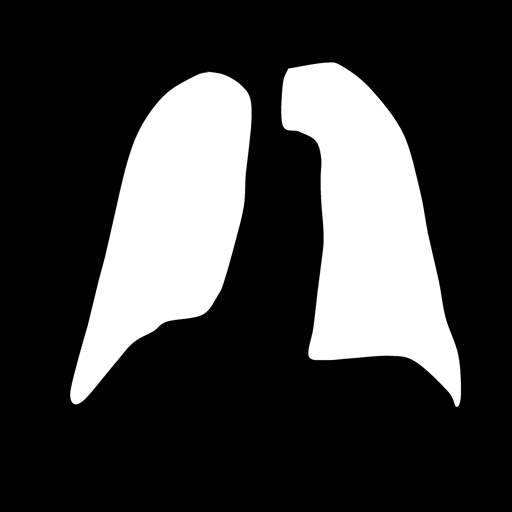

In [ ]:
# Visualize a semantic part segmentation label image
Image.open(sorted(glob("/content/LungSegmentation/masks/*"))[0])

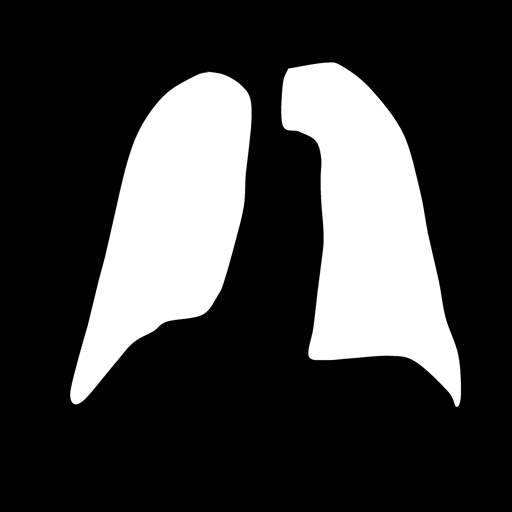

In [ ]:
# Visualize a semantic part segmentation label image
Image.open(sorted(glob("./LungSegmentation/masks/*"))[0])

### Creating a TensorFlow Dataset

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
DATA_DIR = "./LungSegmentation"

# The below line uses the glob function from the glob module to find all the image files in the CXR_png
# subdirectory of the DATA_DIR directory. The resulting list of file paths is sorted in ascending order.
all_images = sorted(glob(os.path.join(DATA_DIR, "CXR_png/*")))

# The below line of code finds all the mask files in the masks
# subdirectory of the DATA_DIR directory.
all_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))

# Creating a list of validation image files by selecting every 14th image from the all_images list.
val_images = all_images[::14]

# Creating a list of validation mask files by selecting every 14th image from the all_masks list.
val_masks = all_masks[::14]

# Creating a list of test image files by selecting every 14th image starting
# from the second image in the all_images list.
test_images = all_images[1::14]

# Creating a list of test mask files by selecting every 14th image starting
# from the second image in the all_masks list.
test_masks = all_masks[1::14]

# Creating an empty list for the training image files.
train_images = []
for i in all_images:
    if (i not in val_images) and (i not in test_images):
        train_images.append(i)

# Creating an empty list for the training image files.
train_masks = []
for i in all_masks:
    if (i not in val_masks) and (i not in test_masks):
        train_masks.append(i)

# The below function reads an image file and returns a preprocessed image tensor.
# The mask argument is set to False by default, indicating that it is an image file, not a mask file.
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1) // 255
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


The **load_data** function created below takes in two arguments, **image_list** and **mask_list**, which are lists of file paths to the images and corresponding masks, respectively. It then reads in the image and mask using the **read_image** function defined earlier. The function returns a tuple of **image** and **mask**.

In [ ]:
def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

The **data_generator** function takes in **image_list** and **mask_list** as arguments. It creates a **tf.data.Dataset** object from the input data using **tf.data.Dataset.from_tensor_slices**. It then maps the **load_data** function to each element in the dataset using **dataset.map**. Finally, it batches the dataset into batches of size **BATCH_SIZE** using **dataset.batch** and sets **drop_remainder=True** to drop any incomplete batch at the end of the dataset. The function returns the resulting dataset.

In [ ]:
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)         # The tf.data.experimental.AUTOTUNE is simply a constant equal to -1.
                                                                                  # This value is passed to allow certain methods to automatically set parameters based on available resources.
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


Further, let us check the total images for train and validation.

In [ ]:
len(train_images), len(val_images)

(602, 51)

Below are the number of batches formed in train and validation set.


In [ ]:
len(train_dataset), len(val_dataset)

(150, 12)

Now, we have created our TensorFlow Dataset. Further, let us try to understand the DeepLabV3+ model.

### Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregate context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dilated_Conv.jpg" width=500px>
<br><br>





#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


### Create the model
First, create different functions  to implement DeepLabV3+ architecture.

Create a function, **convolution_block()**, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [ ]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                      padding="same", use_bias=use_bias,
                      kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

Create another function to perform **Dilated Spatial Pyramid Pooling**. Use above function to add different convolution blocks.

In [ ]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape

    # 1x1 Conv rate=1
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    # 3x3 Conv rate=6
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    # 3x3 Conv rate=12
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    # 3x3 Conv rate=18
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    # Image pooling
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size = (dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation = "bilinear")(x)

    # Concat
    resultant = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])

    # 1x1 Conv
    output = convolution_block(resultant, kernel_size=1)
    return output


The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.


#### Exploring ResNet-50 architecture before using it.

In [ ]:
res_input = keras.Input(shape=(128, 128, 3))
resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor = res_input)

# Layers present in ResNet-50 network
resnet50.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

From the above layers,

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.

### Create Encoder

Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the **conv4_block6_2_relu** layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [ ]:
def Encoder(model_input):
    # Backbone network
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    # Features from backbone network to fead in DSPP
    x = resnet50.get_layer("conv4_block6_2_relu").output
    # DSPP module
    concat_out = DilatedSpatialPyramidPooling(x)
    # 1x1 Conv
    output = convolution_block(concat_out, kernel_size=1)

    return resnet50, output

### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the **conv2_block3_2_relu** layer) from the network backbone that have the same spatial resolution.

In [ ]:
def Decoder(image_size, back_network, x):
    # Output from Encoder, upsample by 4
    input_a = layers.UpSampling2D(size = (image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
                                  interpolation = "bilinear")(x)
    # Low-level features from backbone network
    input_b = back_network.get_layer("conv2_block3_2_relu").output
    # Add 1x1 Conv on low-level features
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    # Concat
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    # Add 3x3 Conv blocks
    x = convolution_block(x)
    x = convolution_block(x)

    # Resultant upsample by 4
    output = layers.UpSampling2D(size = (image_size // x.shape[1], image_size // x.shape[2]),
                            interpolation = "bilinear")(x)
    return output

#### Building full architecture of the Model

Write a function that combines the encoder and decoder functions defined above to create & implement a complete  DeepLabV3+ architecture.

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    # Encoder part
    back_network, x = Encoder(model_input)
    # Decoder part
    x = Decoder(image_size, back_network, x)

    # Output/prediction layer
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
# Create model
model = DeeplabV3Plus(image_size = IMAGE_SIZE, num_classes = NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Training

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

In [ ]:
# Compile model
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = loss,
              metrics = ["accuracy"])

In [ ]:
# Model Training
history = model.fit(train_dataset, validation_data = val_dataset, epochs=10)

Epoch 1/10
150/150 [==============================] - 102s 370ms/step - loss: 0.0796 - accuracy: 0.9704 - val_loss: 0.0919 - val_accuracy: 0.9738
Epoch 2/10
150/150 [==============================] - 54s 359ms/step - loss: 0.0536 - accuracy: 0.9804 - val_loss: 0.0767 - val_accuracy: 0.9737
Epoch 3/10
150/150 [==============================] - 54s 362ms/step - loss: 0.0489 - accuracy: 0.9816 - val_loss: 0.0908 - val_accuracy: 0.9698
Epoch 4/10
150/150 [==============================] - 54s 361ms/step - loss: 0.0466 - accuracy: 0.9822 - val_loss: 0.0652 - val_accuracy: 0.9765
Epoch 5/10
150/150 [==============================] - 54s 358ms/step - loss: 0.0451 - accuracy: 0.9828 - val_loss: 0.1205 - val_accuracy: 0.9632
Epoch 6/10
150/150 [==============================] - 55s 369ms/step - loss: 0.0449 - accuracy: 0.9827 - val_loss: 0.7847 - val_accuracy: 0.8587
Epoch 7/10
150/150 [==============================] - 55s 368ms/step - loss: 0.0430 - accuracy: 0.9833 - val_loss: 0.0845 - val_a

We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

###  Learning curve from model history

In [ ]:
# Function to plot learning curves

def display_learning_curves(model_history):
    acc = model_history.history["accuracy"]
    val_acc = model_history.history["val_accuracy"]
    loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    epochs_range = model_history.epoch

    fig = plt.figure(figsize=(8,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

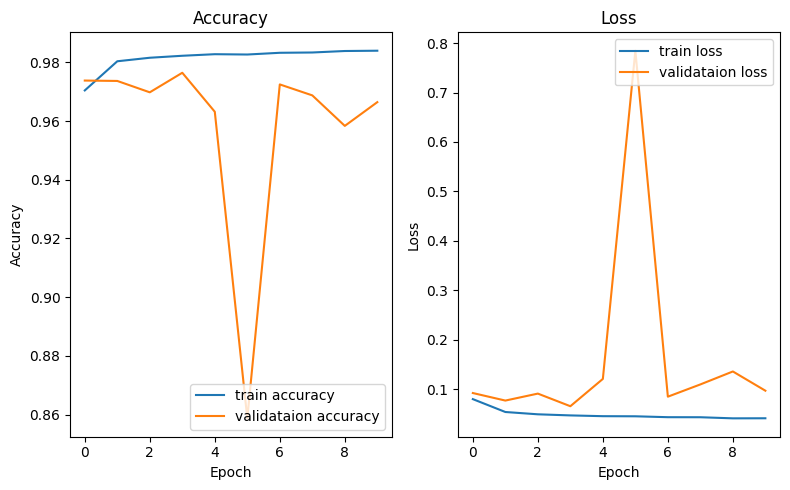

In [ ]:
# Display learning curves
display_learning_curves(history)

### Visualize Predictions

In [ ]:
# Inference from model

def infer(model, image_tensor):
    # predictions from model, output shape -> (1, 512, 512, 2)
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    # Shape after squeeze -> (512, 512, 2)
    predictions = np.squeeze(predictions)
    # Select only maximum predicted value for every pixel, output shape -> (512, 512)
    predictions = np.argmax(predictions, axis=2)
    return predictions

#### Plot the predictions

In [ ]:
def plot_predictions(test_img, test_mask, model = model):
    pred = infer(image_tensor = read_image(test_img), model = model)

    Image.open(test_img)

    fig = plt.figure(figsize=(8,5))

    plt.subplot(1,3,1)
    plt.imshow(Image.open(test_img))
    plt.title("Input image")

    plt.subplot(1,3,2)
    plt.imshow(Image.open(test_mask), cmap="Greys_r")
    plt.title("Actual label")

    plt.subplot(1,3,3)
    plt.imshow(pred, cmap="Greys_r")
    plt.title("Predicted label")

    fig.tight_layout()
    plt.show()

1/1 [==============================] - 2s 2s/step


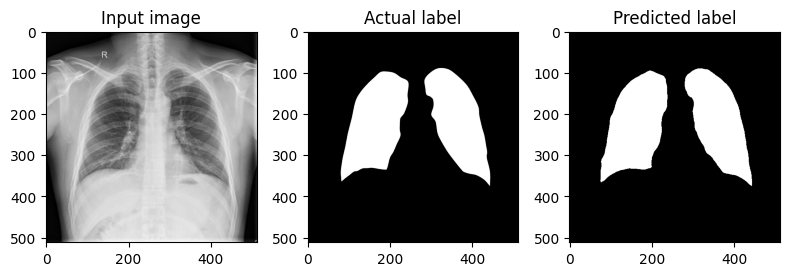

1/1 [==============================] - 0s 27ms/step


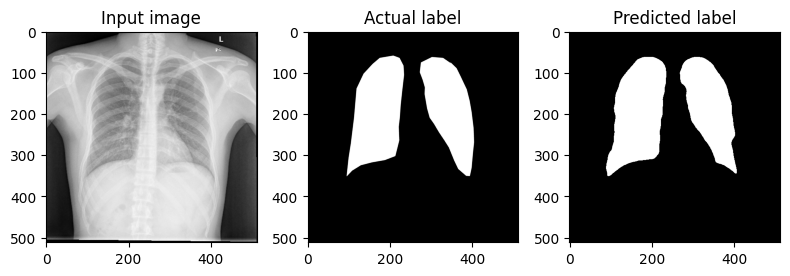

1/1 [==============================] - 0s 25ms/step


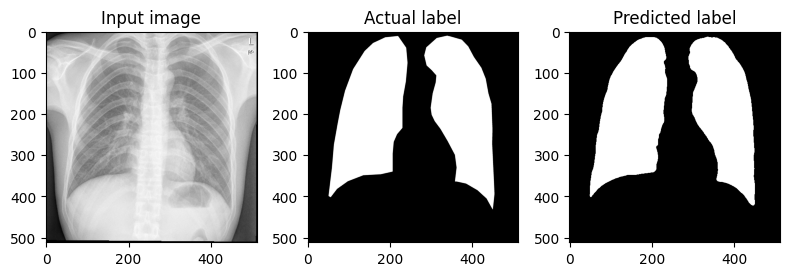

1/1 [==============================] - 0s 28ms/step


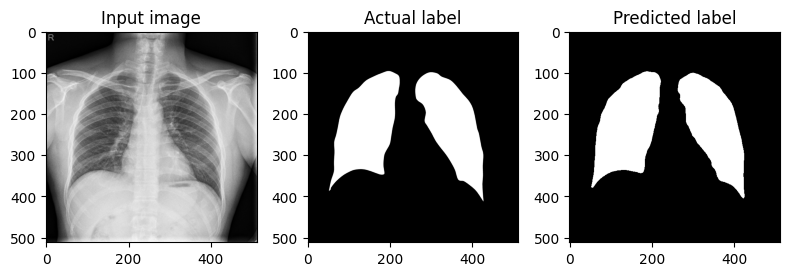

1/1 [==============================] - 0s 23ms/step


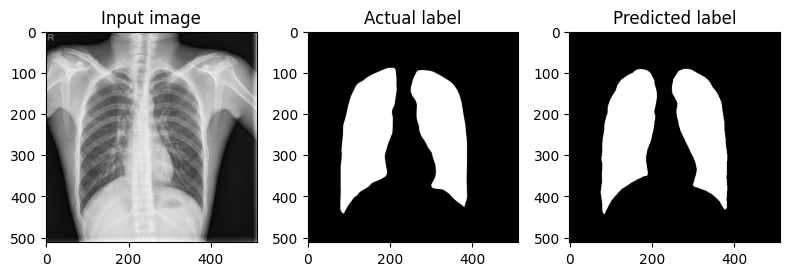

In [ ]:
for i in range(10,15):
    plot_predictions(test_images[i], test_masks[i])